<a href="https://colab.research.google.com/github/oziomaozigbo/SMCR/blob/main/Earth_Heat_2N_ReTuneHT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
import numpy as np , matplotlib.pyplot as plt

# Earth Heat 2N

In [82]:
# ODE4U function
def ode4u(odefun, time, x0, u=None, c=None):
    """
    Solve a system of nonhomogeneous ODEs using the 4th-order Runge-Kutta method.
    (it depends on not just time and state but also external inputs (u) and constanstant (c))

    Parameters:
        odefun : function (t, x, u, c) -> (dxdt, y)
                 returns state derivative and output as arrays
        time   : time values at which the solution is computed.
                 p-dimensional array
        x0     : n-dimensional array, state at time[0].
        u      : (m x p) dimensional array
                 optional input sampled at each time step.
        c      : optional constants passed to odefun.

    Returns:
        time   : ndarray, shape (1, p)
        x_sol  : ndarray, shape (n, p)
        x_drv  : ndarray, shape (n, p)
        y_sol  : ndarray, shape (m, p)
    """

    time   = np.asarray(time)
    x0     = np.asarray(x0).flatten()
    points = len(time) # the total number of time steps

    # create defaults if not provided
    if c is None:
        c = 0
    if u is None:
        u = np.zeros((1, points))
    else:
        u = np.asarray(u)

    # verify inputs recieved are in 2D array shape
    if u.ndim == 1:
        u = u[np.newaxis, :]

    if u.shape[1] < points:
        pad_width = points - u.shape[1]
        u = np.pad(u, ((0, 0), (0, pad_width)), mode='constant')

    # state derivitives and outputs at time[0]
    dxdt0, y0 = odefun(time[0], x0, u[:, 0], c)

    n = x0.size                 # number of states
    m = np.asarray(y0).size     # nuber of outputs

    # allocate memory
    x_sol = np.ones([n, points])*np.nan
    x_drv = np.ones([n, points])*np.nan
    y_sol = np.ones([m, points])*np.nan

    x_sol[:, 0] = x0    # states
    x_drv[:, 0] = dxdt0 # state derivitives
    y_sol[:, 0] = y0    # outputs

    for p in range(points - 1):  # time stepping loop and main integration
        t = time[p]
        dt = time[p + 1] - t
        dt2 = dt / 2.0

        u_mid = (u[:, p] + u[:, p + 1]) / 2.0

        # intermediate dervitives
        dxdt1, _ = odefun(t + dt2, x0 + dxdt0 * dt2, u_mid, c)
        dxdt2, _ = odefun(t + dt2, x0 + dxdt1 * dt2, u_mid, c)
        dxdt3, _ = odefun(t + dt,  x0 + dxdt2 * dt, u[:, p + 1], c)

        # state update using the intermediate derivities
        x0 = x0 + ( dxdt0 + 2 * (dxdt1 + dxdt2) + dxdt3 ) * dt / 6.0

        # state derivitives and outputs at start of time (p+1)
        dxdt0, y0 = odefun(time[p + 1], x0, u[:, p + 1], c)

        # save states (solution), state derivitives, and outputs
        x_sol[:, p+1] = x0    # state
        x_drv[:, p+1] = dxdt1 # state derivitives
        y_sol[:, p+1] = y0    # output

        # safety - incase NaN or Inf
#       if not np.all(np.abs(x0) > 1e12):
        if not np.all(np.isfinite(x0)):
            break

    return time, x_sol, x_drv, y_sol

In [83]:
#!/usr/bin/env python3

# 2N layer heat energy model for the earth's oceans and atmosphere

# https://en.wikipedia.org/wiki/Ocean_temperature
# https://en.wikipedia.org/wiki/Idealized_greenhouse_model
# https://en.wikipedia.org/wiki/Heat_transfer_coefficient
# https://www.engineersedge.com/thermodynamics/overall_heat_transfer-table.htm
# https://enghandbook.com/thermodynamics/heat-transfer/
# https://www.engineeringtoolbox.com/water-steam-thermal-diffusivity-d_2058.html

''' ... in console ...
import importlib , earth_heat_2N
importlib.reload(earth_heat_2N)     # to load edits
'''

# planetary constants
# -------------------
class c:
    pi  =   np.pi
    c   =  299.792458e6         # speed of light  m/s
    h   =    6.62607015e-34     # Planck's constant  J/Hz
    k   =    1.380649e-23       # Boltzmann's constant J/deg K
    sbc =    5.670367e-8        # Stefan-Boltzman constant  ... W/sq.m/deg K^4
    Ts  = 5777.                 # sun temperature, K
    Rs  =    6.9570e08          # radius of sun, m
    D   =    1.4960e11          # sun - to - earth distance, m
    Re  =    6.3567523e6        # radius of earth, m
    sec_per_yr = 365*24*3600    # seconds per year
    aa     =  0.35            #?# earth albedo 0.3 to 0.4 frctn of solar reflected
    ee_atm =  0.78            #?# atmos emissivity without GHG: 0.78 with GHG: 0.80
    ee_ocn =  0.96            #?# ocean emissivity 0.95 to 0.98
    years  = 16                 # years in the simulation
    n_layer = 8                 # layers in the ocean, layers in the atmosphere
#   RF = 4.00                 #?# radiative forcing imbalance  W/sq.m
#   lambda_LW = 4/3           #?# climate feedback parameter W/(sq.m K)
    T_strat = 273 - 60          # temperature of the stratosphere, K
    atm_density_s = 1.23        # density of air at sea level kg/cu.m
    atm_density_t = 0.32        # density of air at top of troposphere kg/cu.m
    atm_shc = 1003              # specific heat capacity of air J/(kg K)
    atm_heat_transfer = 0.5   #?# heat transfer rate of atm 5-30 W/(sq.m K)
    atm_elvtn = 12650            # depth of troposphere m
#   atm_water_cont= 0.004       # volume fraction of water in troposhere
    ocn_atm_heat_transfer=40  #?# heat transfer rate ocn-atm 5 to 50 W/(sq.m K)
    ocn_shc = 4000              # seawater specific heat capacity J/(kg K)
    ocn_density = 1023.6        # seawater density kg/cu.m
    ocn_heat_transfer =  4.0  #?# heat transfer rate of ocn 1-30 W / (sq.m K)
    ocn_depth = 3150            # average ocean depth m
    land_thickness = 8.4        # equivalent water thickness of land, m
    land_area_fraction = 0.292  # fraction of earth that is land . unitless


    # computed constants
    # ------------------
    solar_const = sbc*Ts**4.0 * 4*pi*Rs**2 / (4*pi*D**2.0) # solar constant W/sq.m

    # elevation of layers in the atm
    atm_z = atm_elvtn * np.hstack( [ 0 ,  np.logspace(-1.5,0.0,n_layer) ] )
    # elevation of layers in the ocn
    ocn_z = ocn_depth * np.hstack( [ 0 , -np.logspace(-1.5,0.0,n_layer) ] )

    atm_tz = atm_z[1:n_layer+1] - atm_z[0:n_layer]   # thickness of atm layer
    ocn_tz = ocn_z[0:n_layer]   - ocn_z[1:n_layer+1] # thickness of ocn layer

    atm_dz = 0.5*(atm_z[2:n_layer+1] - atm_z[0:n_layer-1]) # distance between atm layers
    ocn_dz = 0.5*(ocn_z[0:n_layer-1] - ocn_z[2:n_layer+1]) # distance between ocn layers
    ao__dz = 0.5*(atm_z[1] - ocn_z[1])                 # distance between atm&ocn layers

#   print("atm_z = " , np.round(atm_z))
#   print("ocn_z = " , np.round(ocn_z))
    print("ao__dz = ", np.round(ao__dz))

#   atmospheric density linear with altitude
#   atm_density = atm_density_s + (atm_density_t-atm_density_s)*atm_z/atm_elvtn
#   atmospheric density exponential with altitude
    atm_density_decay = atm_elvtn/np.log(atm_density_s / atm_density_t)
    atm_density = atm_density_s * np.exp(-(atm_z[0:n_layer]+0.5*atm_tz)/atm_density_decay)

#   print("atm_density", atm_density)

#   troposphere area heat capacity (per sq.m) J/(sq.m K)
    atm_ahc = atm_shc * atm_density * atm_tz
#   atm_ahc = ocn_shc * ocn_density * 50.0 # 50 m of water in 13000 m of atm
#   ocean       area heat capacity (per sq.m) J/(sq.m K)
    # ocn_ahc = ocn_shc * ocn_density * ocn_tz
# Effective ocean + land heat capacity (J/m²·K)
# weight ocean mixed-layer capacity by ocean area and land by equivalent water thickness
c.ocn_ahc = ((1.0 - c.land_area_fraction) * c.ocn_shc * c.ocn_density * c.ocn_tz +
             c.land_area_fraction * c.ocn_shc * c.ocn_density * c.land_thickness)

# Tuned parameters for equilibrium
# These were calibrated so that:
#   - Deep ocean ≈ 2–3 °C
#   - Top ocean layer ≈ 19 °C
#   - Bottom of atmosphere ≈ 15 °C
# at steady state (after multi-year integration).

c.aa = 0.29                    # albedo (fraction reflected)
c.ee_atm = 0.78                # atmospheric emissivity
c.ee_ocn = 0.96                # ocean emissivity

# Heat transfer coefficients (W/m²·K)
c.atm_heat_transfer = 7.0      # internal atm conduction/convection
c.ocn_heat_transfer = 1.6      # vertical mixing in ocean
c.ocn_atm_heat_transfer = 28.0 # air–sea interface exchange

print("Effective combined ocean/land heat capacity: {:.3e} J/m²·K".format(np.mean(c.ocn_ahc)))
print("Tuned transfer coefficients:")
print(f"  atm_heat_transfer      = {c.atm_heat_transfer:.2f} W/m²·K")
print(f"  ocn_heat_transfer      = {c.ocn_heat_transfer:.2f} W/m²·K")
print(f"  ocn_atm_heat_transfer  = {c.ocn_atm_heat_transfer:.2f} W/m²·K")

# define the dynamical system in terms of a set of o.d.e's
# --------------------------------------------------------
def sys(t, x, u, c):
    """
    compute the state derivives dxdt given current state, time, and input
    x = [ Q_atm , Q_ocn ] states ... heat in atmosphere and ocean J/sq.m
    """

    N  = c.n_layer
    # extract individual states from the vector of states , J/sq.m
    Q_atm = x[ 0 :   N ]       #   x( 0 :   N-1 )
    Q_ocn = x[ N : 2*N ]       #   x( N : 2*N-1 )

#   print("x= ", x)
#   print("Q_atm= ", Q_atm)
#   print("Q_ocn= ", Q_ocn)

    # convert from heat to temperature , K
    T_atm = np.maximum( 0.0 , Q_atm / c.atm_ahc )    # atmosphere deg K
    T_ocn = np.maximum( 0.0 , Q_ocn / c.ocn_ahc )    #   ocean    deg K

#   print("T_atm = ", T_atm)
#   print("T_ocn = ", T_ocn)

#   Atmosphere Heat .....................................
    dQ_atm_dt = np.ones(N)*np.nan

    R_out_U = c.ee_ocn * c.sbc * T_ocn[0]**4.0
    h_U = c.atm_heat_transfer

    for k in range(N):
        T_L = T_atm[k-1]
        h_L = c.atm_heat_transfer
        if k == 0:
            T_L = T_ocn[0]
            h_L = c.ocn_atm_heat_transfer
        if k == N-1:
            T_U = c.T_strat
        else:
            T_U = T_atm[k+1]

        # radiative inputs and outputs in an atmosphere layer
        # ---------------------------------------------------
        # radiant heat input through a layer's lower surface is
        # the radiant heat out of the lower layer's upper surface ...
        R_in_L  = R_out_U
        # radiant heat input through a layer's upper surface is
        # the radiant heat out of the upper layer's lower surface ...
        R_in_U  = c.ee_atm * c.sbc * T_U**4.0
        # radiant heat output through a layer's lower surface
        # depends on the layer's emissivity and the layer's temperature
        # and the radiant heat from transmitted through
        # the layer's upper surface that is not absorbed by the layer
        R_out_L = (1-c.ee_atm) * R_in_U  +  c.ee_atm * c.sbc * T_atm[k]**4.0
        # radiant heat output through a layer's upper surface
        # depends on the layer's emissivity and the layer's temperature
        # and the radiant heat from transmitted through
        # the layer's upper surface that is not absorbed by the layer
        R_out_U = (1-c.ee_atm) * R_in_L  +  c.ee_atm * c.sbc * T_atm[k]**4.0

        # rate of change in heat within atmosphere layer number "k"
        dQ_atm_dt[k] = R_in_L + R_in_U - R_out_L - R_out_U \
                       + h_L * (T_L - T_atm[k])  +  h_U * (T_U - T_atm[k])

#   Ocean Heat ......................................
    dQ_ocn_dt = np.ones(N)*np.nan

    h_L = c.ocn_heat_transfer

    for k in range(N):
        T_U = T_ocn[k-1]
        h_U = c.ocn_heat_transfer
        u0 = 0
        if k == 0:
            T_U = T_atm[0]
            h_U = c.ocn_atm_heat_transfer
            u0 = u[0]  -  c.ee_ocn*c.sbc*T_ocn[0]**4.0 \
                + (1-c.ee_atm)*c.sbc*T_atm[1]**4.0 \
                +     c.ee_atm*c.sbc*T_atm[0]**4.0
        if k == N-1:
            h_L = 0
            T_L = T_ocn[k]
        else:
            T_L = T_ocn[k+1]

        # rate of change in heat within ocean layer number "k"
        dQ_ocn_dt[k] = u0 + h_L * (T_L - T_ocn[k]) + h_U * (T_U - T_ocn[k])

#   RF Radiative Feedback ...........................
    RF = c.sbc * ( (1-c.ee_atm)*T_atm[1]**4.0 + c.ee_atm * T_atm[0]**4.0 \
                                              - c.ee_ocn * T_ocn[0]**4.0 )
#   print("RF = ", RF)

#   state derivitive ................................
    dxdt = np.hstack( [ dQ_atm_dt , dQ_ocn_dt ] ) # rate of change of heat per sq.m

#   output ..........................................
    y = np.hstack( [ T_atm , T_ocn , RF  ] )

    return dxdt, y


# simulate the dynamical system
# -----------------------------
def run():
    N = c.n_layer
    # time
    # --------------------
    time_end     = c.sec_per_yr  * c.years           # final time, s
    time_step    = c.sec_per_yr  / (12*365)          # time step, s
    n_time       = int( time_end / time_step )
    dt           = time_step * np.ones(n_time)
    n_ramp       = int( c.sec_per_yr * 9 / time_step )
    k_ramp       = np.linspace(0,n_ramp-1,n_ramp)
    dt[0:n_ramp] = time_step*( np.sin(2*np.pi*k_ramp/n_ramp/4) )**2.0
    time         = np.cumsum(dt);

    print("time_step=", time_step/3600, "hr ...  number of time steps=", n_time)
#   print("n_time_init=", n_time_init, "time_step_init=", time_step_init )

    # initial state values
    # --------------------
    # initial temp in the atmosphere and oceans deg.K
#   T_atm_init = np.linspace( 1 , -1 , N )
#   T_ocn_init = np.linspace( 1 ,  1 , N )
#   T_atm_init = np.linspace( 15 , -59 , N )
#   T_ocn_init = np.linspace( 17 ,   2 , N )
    T_atm_init = np.array( [ 15.,  -3.,  -17., -30., -40., -49., -55., -59.] )
    T_ocn_init = np.array( [ 19.,  17.,   14.,  12.,   9.,   7.,   4.,   3.] )

    print("T_atm_init = ", np.round( T_atm_init ) )
    print("T_ocn_init = ", np.round( T_ocn_init ) )

    x_init = np.hstack([ c.atm_ahc*(T_atm_init+273) , \
                         c.ocn_ahc*(T_ocn_init+273) ])

#   print("x_init = ", x_init)

    # external forcing
    # --------------------
    # short wavelength solar input over the surface W/sq.m
    u = (1-c.aa)*(c.solar_const/4)*np.ones(n_time)

#   print("u0 = ", u[0])

    # solve the ode's for heat and temperature in the atmosphere and ocean
    # --------------------------------------------------------------------
    time, x, x_drv, y = ode4u( sys , time , x_init , u , c )

    time = time / c.sec_per_yr

    T_atm = y[0:N,:]   - 273;    # deg C
    T_ocn = y[N:2*N,:] - 273;    # deg C
    RF    = y[2*N];

    # print some results
    # ----------------------------------------------------
#   print("sbc=",c.sbc, "So=", c.So, "u=",u[0])
    print("Year= ",np.round(time[-1]))
    print("The temperatures in the atmosphere layers:" )
    print(" T_atm",np.round(time[-1]),"= ",np.round(T_atm[:,-1]))
    print(" T_atm[0]",np.round(time[-1]),"= ",T_atm[0,-1])
    print("The temperatures in the    ocean    layers:" )
    print(" T_ocn",np.round(time[-1]),"= ",np.round(T_ocn[:,-1]))
    print(" T_ocn[0]",np.round(time[-1]),"= ",T_ocn[0,-1])
#   print("atm_ahc=", c.atm_ahc/1e6, "ocn_ahc=", c.ocn_ahc/1e6)

    # ---------------------------------------------------------- Plots
    fontsize = 12
    plt.rcParams['font.size'] = fontsize
    plt.ion()                 # interactive mode

#   f10 = plt.figure(10) # ---------------------------------------
#   plt.clf()
#   plt.plot(time, dt,  "-", color='Black')
#   plt.ylabel('delta-t')
#   plt.xlabel('Time (years)')
#
#   f11 = plt.figure(11) # ---------------------------------------
#   plt.clf()
#   plt.plot(time,  "-", color='Black')
#   plt.ylabel('t')
#   plt.xlabel('time index number ')
#
#   f0 = plt.figure(0) # ---------------------------------------
#   plt.clf()
#   plt.plot(time, u, "-", color='Red')
#   plt.ylabel('Short Wavelentgh Solar Input at Surface W/sq.m')
#   plt.xlabel('Time (years)')

    f1 = plt.figure(1) # ---------------------------------------
#   fig=plt.figure(figsize=(4.2,4.3),dpi=300)
    plt.clf()
#   plt.subplot(3,1,1)

    plt.plot(time, T_atm[0,:], "-", color='SkyBlue', label="atmosphere")
    plt.plot(time, T_ocn[0,:], "-", color='MidnightBlue', label="ocean")
    plt.plot(time[-1], T_atm[0,-1], "o", color='SkyBlue')
    plt.plot(time[-1], T_ocn[0,-1], "o", color='MidnightBlue')
    for k in range(1,N):
        plt.plot(time, T_atm[k,:], "--", color='SkyBlue' )
        plt.plot(time, T_ocn[k,:], "--", color='MidnightBlue')
    plt.ylabel('Temperature (°C)')
    plt.xlabel('Time (years)')
#   plt.xlim([0,200])
#   plt.ylim([0,4])
#   plt.title('Atm/ Ocean temperature anomalies given a sudden 2x CO฀ increase')
    plt.legend(loc='lower right',fontsize=fontsize-1)
    plt.grid(lw=0.25)
    plt.title("(a)",loc="left",fontsize=fontsize)

    f2 = plt.figure(2) # ---------------------------------------
#   fig=plt.figure(figsize=(4.2,4.3),dpi=300)
    plt.clf()
#   plt.subplot(3,1,1)

    plt.plot(time, y[2,:], "-", color='Orange')
    plt.ylabel('RF W/sq.m')
    plt.xlabel('Time (years)')
#   plt.xlim([0,200])
#   plt.ylim([0,4])
#   plt.title('Atm/ Ocean temperature anomalies given a sudden 2x CO฀ increase')
#   plt.legend(loc='right',fontsize=fontsize-1)
    plt.grid(lw=0.25)
    plt.title("(b)",loc="left",fontsize=fontsize)

    plt.show()

ao__dz =  250.0
Effective combined ocean/land heat capacity: 1.151e+09 J/m²·K
Tuned transfer coefficients:
  atm_heat_transfer      = 7.00 W/m²·K
  ocn_heat_transfer      = 1.60 W/m²·K
  ocn_atm_heat_transfer  = 28.00 W/m²·K


time_step= 2.0 hr ...  number of time steps= 70080
T_atm_init =  [ 15.  -3. -17. -30. -40. -49. -55. -59.]
T_ocn_init =  [19. 17. 14. 12.  9.  7.  4.  3.]
Year=  11.0
The temperatures in the atmosphere layers:
 T_atm 11.0 =  [ 11.  -4. -17. -28. -38. -46. -52. -57.]
 T_atm[0] 11.0 =  11.113741336936869
The temperatures in the    ocean    layers:
 T_ocn 11.0 =  [18. 16. 14. 12.  9.  7.  4.  3.]
 T_ocn[0] 11.0 =  18.272411791601485


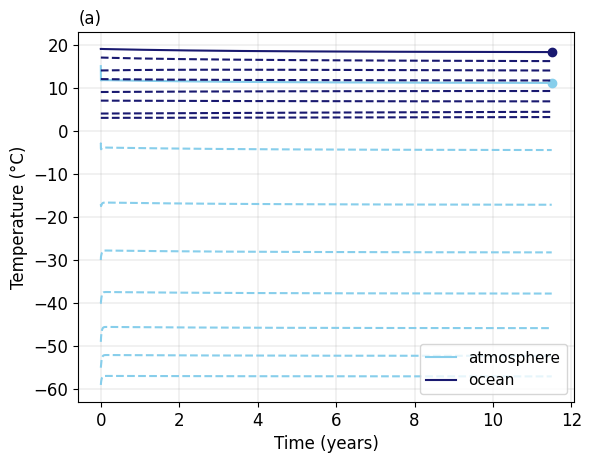

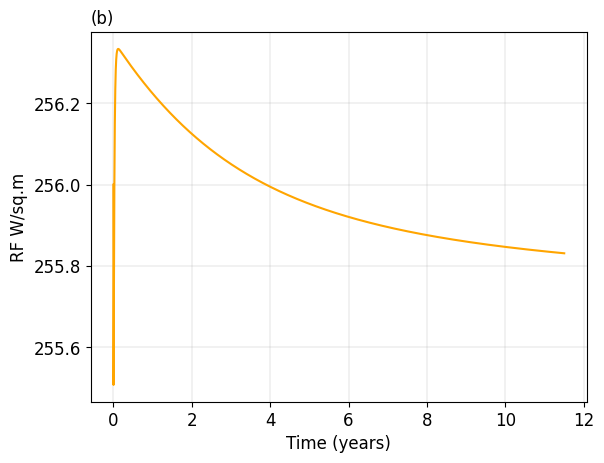

In [84]:
run()